In [1]:
from xgboost import XGBClassifier
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import read_csv
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


In [2]:
data = pd.read_csv('./UsedCombined.txt',sep='\t')
data = data.drop(columns = ['Unnamed: 0'])
removeList = ['Sex','neutrophilCategorical','serumLevelsOfWhiteBloodCellCategorical','lymphocytesCategorical','CTscanResults','XrayResults','Diarrhea','Fever','Coughing','SoreThroat','NauseaVomitting','Fatigue','RenalDisease','diabetes']
for i in removeList:
    data = pd.concat([data,pd.get_dummies(data[i], prefix=i)],axis=1)
data = data.drop(columns=removeList)
data= data.drop(columns = ['Diagnosis'])
data = data.loc[data['Sex_F'] == 1]
X, y = data.iloc[:,1:],data.iloc[:,0]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) # step size equals 20% of data, random state just a random number to ensure reproducibility

In [4]:
X

,Age,neutrophil,serumLevelsOfWhiteBloodCell,lymphocytes,Temperature,Sex_F,Sex_M,neutrophilCategorical_high,neutrophilCategorical_low,neutrophilCategorical_normal,...,SoreThroat_No,SoreThroat_Yes,NauseaVomitting_No,NauseaVomitting_Yes,Fatigue_No,Fatigue_Yes,RenalDisease_No,RenalDisease_Yes,diabetes_No,diabetes_Yes
0,67.000,NaN,NaN,NaN,38.111111,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,22.000,NaN,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20.000,NaN,NaN,NaN,36.555556,1,0,0,0,0,...,1,0,0,0,0,1,1,0,1,0
5,22.000,NaN,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,19.000,NaN,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,46.000,NaN,NaN,NaN,38.611111,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
12,55.000,NaN,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,29.000,NaN,NaN,NaN,37.833333,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
15,60.000,NaN,NaN,NaN,36.777778,1,0,0,0,0,...,1,0,0,0,1,0,1,0,0,1
16,63.000,NaN,NaN,NaN,37.444444,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,1


In [5]:
XGBCL = XGBClassifier()
classifier1 = XGBCL.fit(X_train,y_train)
preds = classifier1.predict(X_test)

C:\Users\Harrison\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [6]:
print(classification_report(preds, y_test))
cm = confusion_matrix(preds, y_test)
acc = cm.diagonal().sum()/cm.sum()
print(acc)

             precision    recall  f1-score   support

          0       0.97      0.95      0.96        96
          1       0.87      0.92      0.89        36

avg / total       0.94      0.94      0.94       132

0.9393939393939394


In [7]:
dtrain = xgb.DMatrix(X_train, label=y_train)

In [8]:
#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
     params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'rmse'}
     #Cross validating with the specified parameters in 5 folds and 70 iterations
     cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
     #Return the negative RMSE
     return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                             'gamma': (0, 1),
                                             'learning_rate':(0,1),
                                             'n_estimators':(100,120)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.2996   |  0.6253   |  0.4712   |  3.533    |  116.6    |
|  2        | -0.2999   |  0.854    |  0.7343   |  7.208    |  115.9    |
|  3        | -0.3155   |  0.9695   |  0.8798   |  5.568    |  111.1    |
|  4        | -0.3162   |  0.7299   |  0.8429   |  9.917    |  112.4    |
|  5        | -0.291    |  0.8739   |  0.1893   |  4.917    |  102.0    |
|  6        | -0.3109   |  0.4676   |  0.8235   |  3.026    |  119.3    |
|  7        | -0.2803   |  0.5348   |  0.412    |  4.86     |  111.9    |
|  8        | -0.279    |  0.03786  |  0.4355   |  4.066    |  106.1    |
|  9        | -0.5      |  0.0      |  0.0      |  10.0     |  120.0    |
|  10       | -0.5      |  0.0      |  0.0      |  10.0     |  100.0    |
|  11       | -0.5      |  0.0      |  0.0      |  3.0      |  100.0    |
|  12       | -0.5      |  1.0      | 

In [9]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)
#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#train using best parameters
classifier2 = XGBClassifier(**params).fit(X_train,y_train)
preds2 = classifier2.predict(X_test)

{'gamma': 0.03786156865521295, 'learning_rate': 0.4355009559995684, 'max_depth': 4.065739160788145, 'n_estimators': 106.13421947726586}


C:\Users\Harrison\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [10]:
#Accuracy obtained on the training set
print(classification_report(preds2, y_test))
cm = confusion_matrix(preds2, y_test)
acc = cm.diagonal().sum()/cm.sum()
print(acc)
print(cm)

             precision    recall  f1-score   support

          0       0.97      0.93      0.95        98
          1       0.82      0.91      0.86        34

avg / total       0.93      0.92      0.93       132

0.9242424242424242
[[91  7]
 [ 3 31]]


In [11]:
lr_probs = classifier2.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_probs = [0 for _ in range(len(y_test))]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

In [12]:
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.981


In [13]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

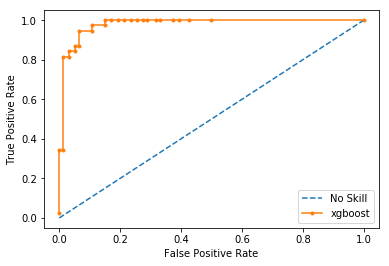

In [14]:
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='xgboost')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.savefig('rocWithoutNan.pdf',format = 'pdf')

In [15]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [16]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

In [17]:
yhat = classifier2.predict(X_test)
lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

C:\Users\Harrison\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
print('Classifier: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Classifier: f1=0.861 auc=0.948


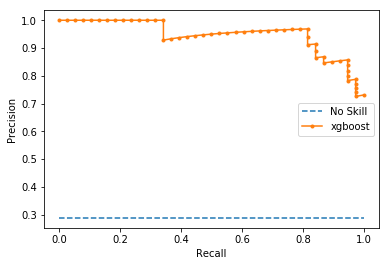

In [19]:
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='xgboost')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.savefig('precision-recallWithoutNan.pdf',format = 'pdf')

C:\Users\Harrison\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Harrison\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Harrison\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


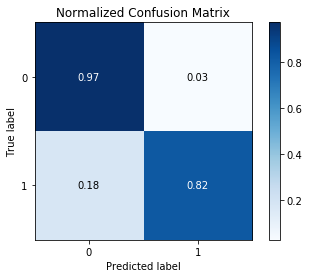

In [24]:
import scikitplot as skplt
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(classifier2, X_test, y_test)
skplt.metrics.plot_confusion_matrix(y_test, preds2, normalize=True)
pyplot.savefig('confusionWithoutNan.pdf',format = 'pdf')

In [25]:
rmse = np.sqrt(mean_squared_error(y_test, preds2))
print("RMSE: %f" % (rmse))

RMSE: 0.275241


In [26]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
import graphviz
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)
import matplotlib.pyplot as plt

[03:06:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\learner.cc:328: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




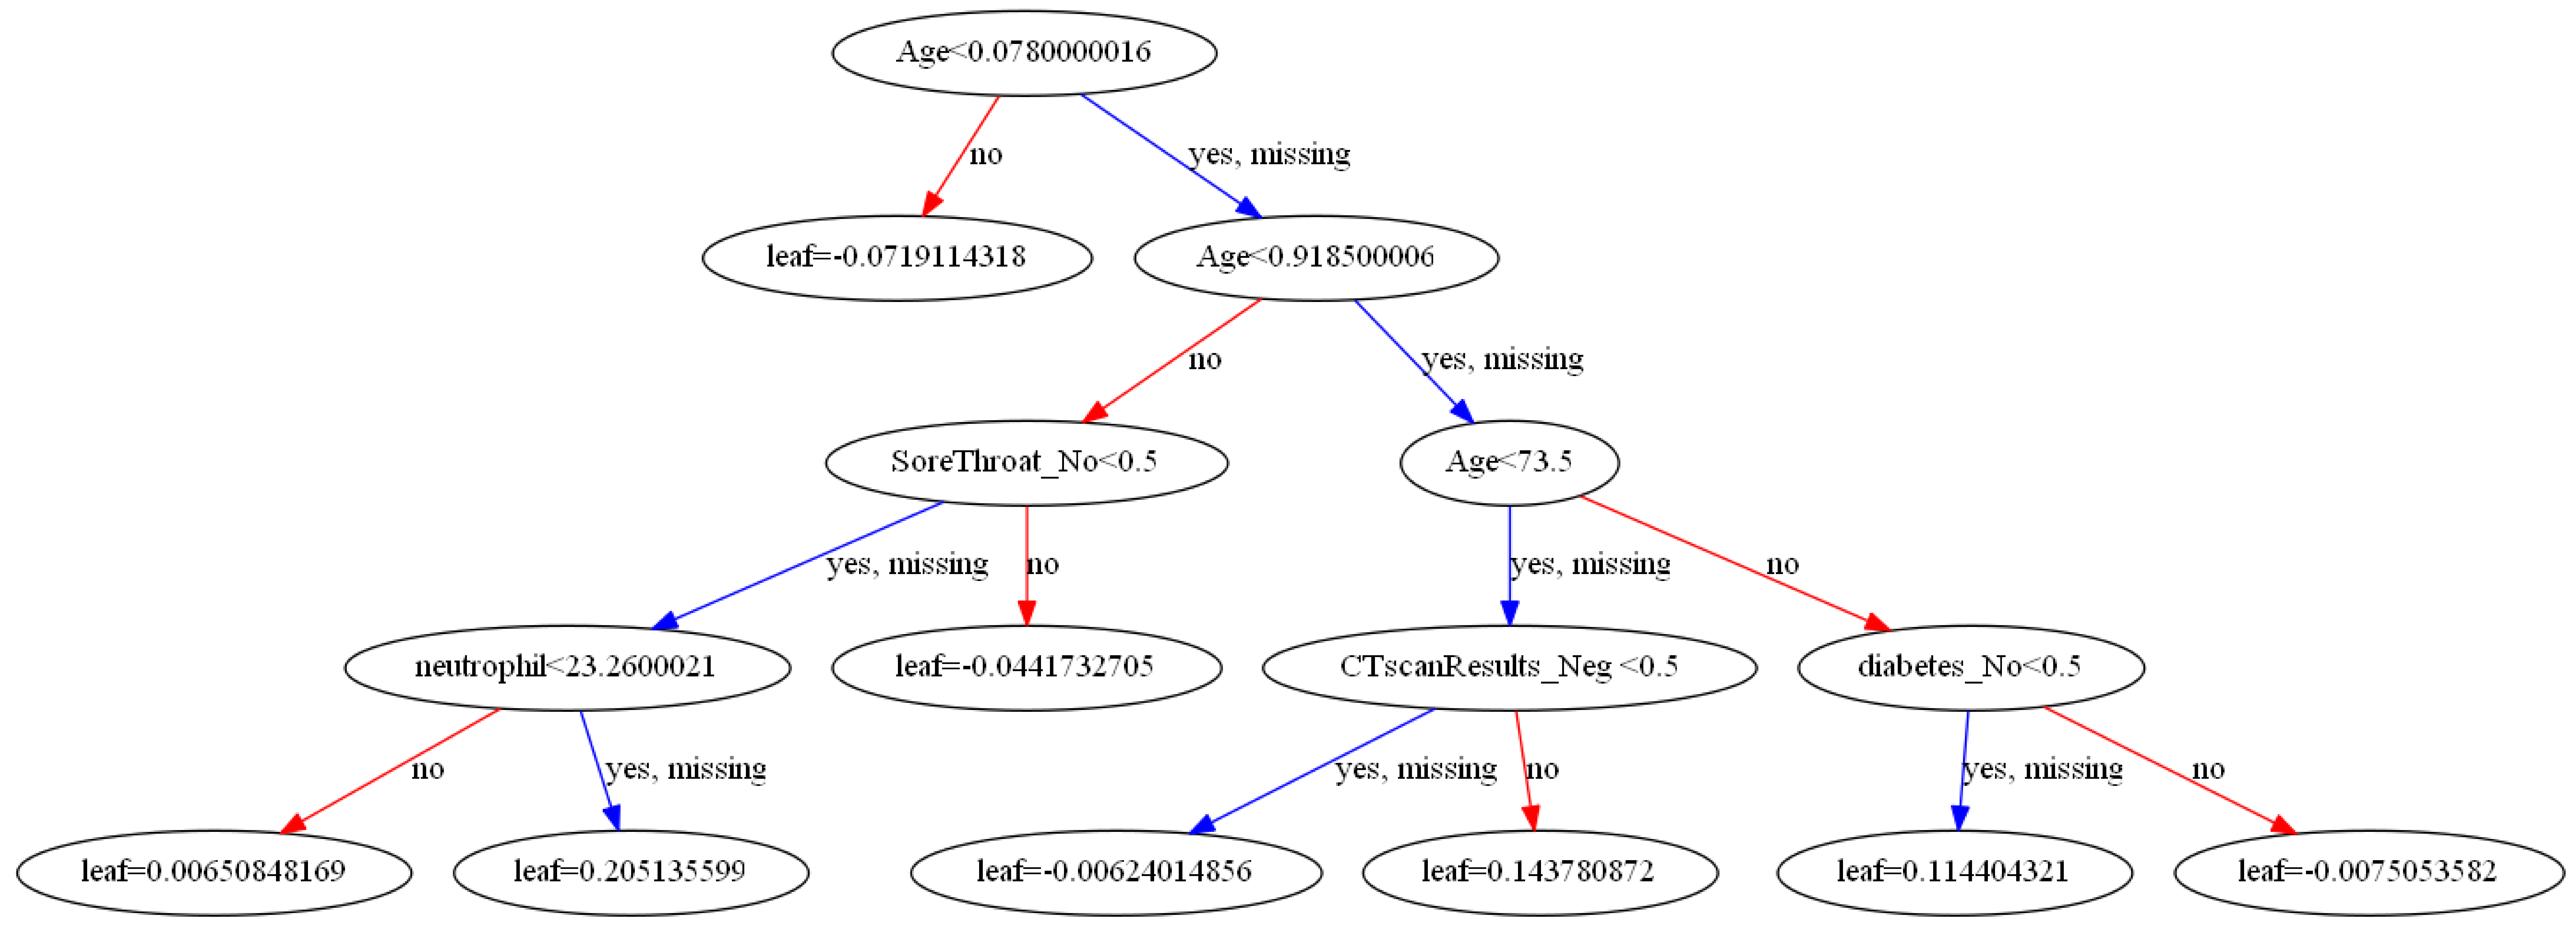

In [31]:
xgb.plot_tree(xg_reg,num_trees=6)
plt.rcParams['figure.figsize'] = [100, 200]
#plt.show()
#plt.savefig('treeWithoutNanF.pdf',format='pdf',dpi=3600)

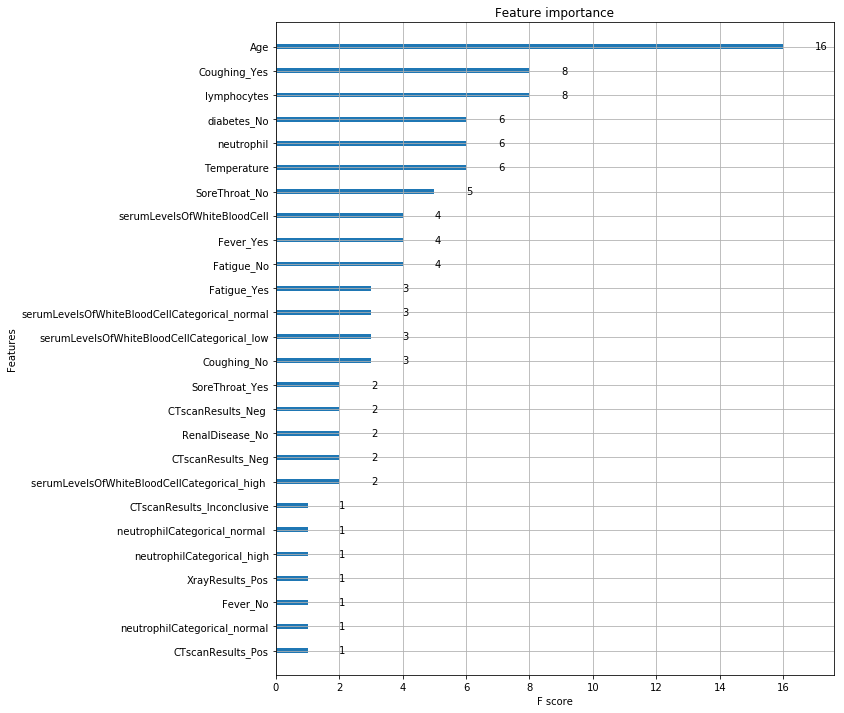

In [33]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
#plt.show()
pyplot.savefig('barWithoutNan.pdf',format='pdf')